# 03_model_training_and_shap.ipynb
**An Interpretable ML Framework for Estimating Postmortem Interval (PMI)**  
**Notebook 3 — Model training, evaluation and SHAP interpretability**


In [ ]:
!pip install -q scikit-learn xgboost shap matplotlib seaborn joblib


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import shap

sns.set_theme(style="whitegrid")
RND = 42


# 03_model_training_and_shap.ipynb
**An Interpretable ML Framework for Estimating Postmortem Interval (PMI)**  
**Notebook 3 — Model training, evaluation and SHAP interpretability**


In [2]:
!pip install -q scikit-learn xgboost shap matplotlib seaborn joblib

Imports & config

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import shap

sns.set_theme(style="whitegrid")
RND = 42


Load processed data

In [4]:
processed_path = "data/processed/synthetic_pmi_processed.csv"
assert os.path.exists(processed_path), f"Processed dataset not found at {processed_path} — run notebook 02 first."
df = pd.read_csv(processed_path)
print("Loaded processed dataset:", processed_path, "shape:", df.shape)
df.head()


Loaded processed dataset: data/processed/synthetic_pmi_processed.csv shape: (8778, 17)


,pmi_hours,true_pmi_hours,body_temp_c,ambient_temp_c,humidity_pct,surface_type,clothing_insulation,clothing_wet,bmi,rigor_stage,livor_stage,decomposition_score,insect_activity_index,wound_present,contact_area_pct,sun_exposure,pmi_bin
0,12.364,14.078,36.261,29.910,67,indoors,2.723,0,26.395,3,2,0.007,0.000,0,46.87,0,6-24h
1,22.651,22.318,31.732,18.971,36,indoors,2.016,0,17.381,1,2,0.845,0.000,0,46.39,0,6-24h
2,36.395,28.060,26.901,14.288,42,indoors,0.908,0,19.892,4,2,0.000,0.000,0,87.30,0,1-3d
3,9.337,9.894,34.676,20.643,61,concrete,0.815,0,27.911,2,1,0.892,1.889,0,48.02,0,6-24h
4,10.278,11.175,33.727,17.281,71,concrete,2.556,0,19.811,3,2,0.000,1.635,0,62.18,0,6-24h


Prepare features & target

In [5]:
# Drop any columns that are not features (keep pmi_hours as target)
target = "pmi_hours"
drop_cols = []  # if any extra columns to drop, add here (e.g., true_pmi_hours if you want)
if 'true_pmi_hours' in df.columns:
    # keep it only for analysis but not as a feature
    df = df.drop(columns=['true_pmi_hours'])

X = df.drop(columns=[target])
y = df[target].values

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['body_temp_c', 'ambient_temp_c', 'humidity_pct', 'clothing_insulation', 'clothing_wet', 'bmi', 'rigor_stage', 'livor_stage', 'decomposition_score', 'insect_activity_index', 'wound_present', 'contact_area_pct', 'sun_exposure']
Categorical features: ['surface_type', 'pmi_bin']


Preprocessing pipeline

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
], remainder='drop')

# Handy function to get transformed feature names (for SHAP & inspection)
def get_feature_names(preprocessor):
    num_feats = numeric_features
    cat_transformer = preprocessor.named_transformers_.get('cat')
    if cat_transformer is not None:
        try:
            cat_names = cat_transformer.get_feature_names_out(categorical_features).tolist()
        except Exception:
            # fallback in case older sklearn version or other issue
            cat_names = []
    else:
        cat_names = []
    return num_feats + cat_names


# Train/test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RND)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (7022, 15) Test shape: (1756, 15)


Define evaluation helper

In [10]:
pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [8]:
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    # Proportion within thresholds
    diffs = np.abs(y_true - y_pred)
    within_1 = (diffs <= 1.0).mean()
    within_6 = (diffs <= 6.0).mean()
    within_12 = (diffs <= 12.0).mean()
    within_24 = (diffs <= 24.0).mean()
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'within_1h': within_1,
        'within_6h': within_6,
        'within_12h': within_12,
        'within_24h': within_24
    }


Baseline model: Lasso (linear)

In [17]:
# Lasso baseline
lasso_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', Lasso(alpha=0.1, random_state=RND, max_iter=5000))
])

%time lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)
metrics_lasso = evaluate_regression(y_test, y_pred_lasso)
print("Lasso metrics:", metrics_lasso)


CPU times: user 16 ms, sys: 897 µs, total: 16.9 ms
Wall time: 17.7 ms
Lasso metrics: {'MAE': 4.8986, 'RMSE': np.float64(6.6663), 'R2': 0.9211}


Strong baseline: RandomForest

In [18]:
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=RND, n_jobs=-1))
])

%time rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
metrics_rf = evaluate_regression(y_test, y_pred_rf)
print("RandomForest metrics:", metrics_rf)


CPU times: user 29.4 s, sys: 214 ms, total: 29.6 s
Wall time: 20.9 s
RandomForest metrics: {'MAE': 3.2371, 'RMSE': np.float64(4.6287), 'R2': 0.962}


XGBoost

In [19]:
from xgboost import XGBRegressor
xgb_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', XGBRegressor(n_estimators=200, random_state=RND, n_jobs=4, verbosity=0))
])
%time xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
metrics_xgb = evaluate_regression(y_test, y_pred_xgb)
print("XGBoost metrics:", metrics_xgb)


CPU times: user 1.55 s, sys: 15.1 ms, total: 1.57 s
Wall time: 857 ms
XGBoost metrics: {'MAE': 3.2946, 'RMSE': np.float64(4.5537), 'R2': 0.9632}


Compare model metrics

In [20]:
metrics_df = pd.DataFrame([
    {'model': 'Lasso', **metrics_lasso},
    {'model': 'RandomForest', **metrics_rf},
    {'model': 'XGBoost', **metrics_xgb}
])
metrics_df = metrics_df.set_index('model')
metrics_df


,MAE,RMSE,R2
model,,,
Lasso,4.8986,6.6663,0.9211
RandomForest,3.2371,4.6287,0.9620
XGBoost,3.2946,4.5537,0.9632


Visualize predictions vs true

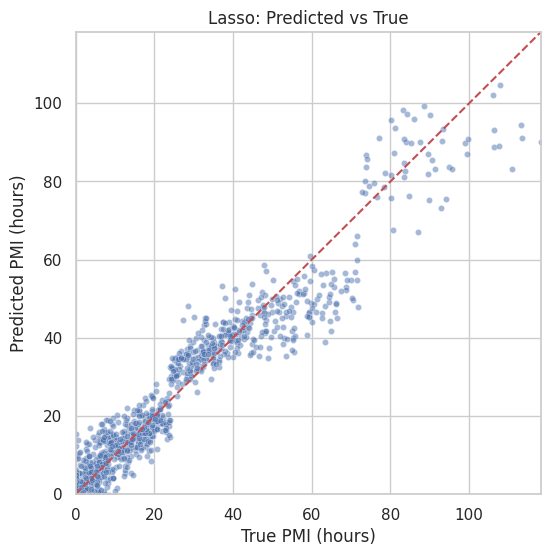

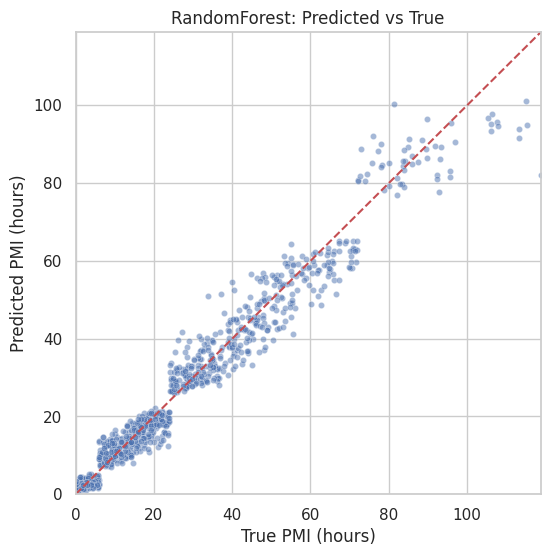

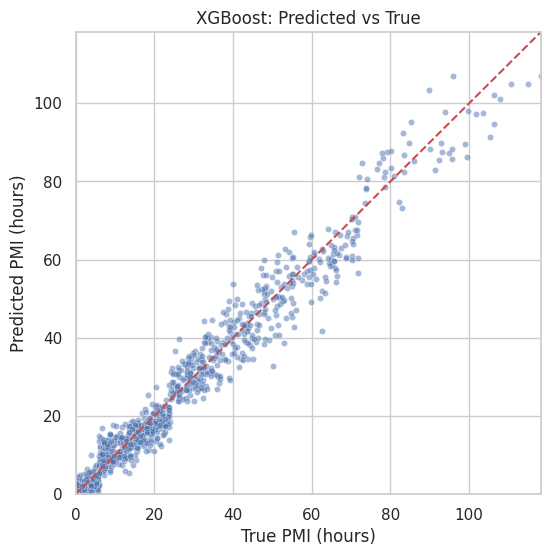

In [21]:
def plot_pred_vs_true(y_true, y_pred, title=None, n=1000):
    idx = np.random.choice(len(y_true), size=min(n, len(y_true)), replace=False)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true[idx], y=y_pred[idx], alpha=0.5, s=20)
    lim = max(max(y_true[idx].max(), y_pred[idx].max()), 1)
    plt.plot([0, lim], [0, lim], 'r--')
    plt.xlabel("True PMI (hours)")
    plt.ylabel("Predicted PMI (hours)")
    if title:
        plt.title(title)
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.show()

plot_pred_vs_true(y_test, y_pred_lasso, title="Lasso: Predicted vs True")
plot_pred_vs_true(y_test, y_pred_rf, title="RandomForest: Predicted vs True")
plot_pred_vs_true(y_test, y_pred_xgb, title="XGBoost: Predicted vs True")


Feature names for SHAP

In [22]:
# Fit preprocessor on full training set to get feature names
preprocessor.fit(X_train)
feature_names = get_feature_names(preprocessor)
print("Total transformed features:", len(feature_names))
# Show first 30
feature_names[:30]


Total transformed features: 21


['body_temp_c',
 'ambient_temp_c',
 'humidity_pct',
 'clothing_insulation',
 'clothing_wet',
 'bmi',
 'rigor_stage',
 'livor_stage',
 'decomposition_score',
 'insect_activity_index',
 'wound_present',
 'contact_area_pct',
 'sun_exposure',
 'surface_type_concrete',
 'surface_type_grass',
 'surface_type_indoors',
 'surface_type_water',
 'pmi_bin_1-3d',
 'pmi_bin_6-24h',
 'pmi_bin_<6h',
 'pmi_bin_>3d']

SHAP explanations for RandomForest

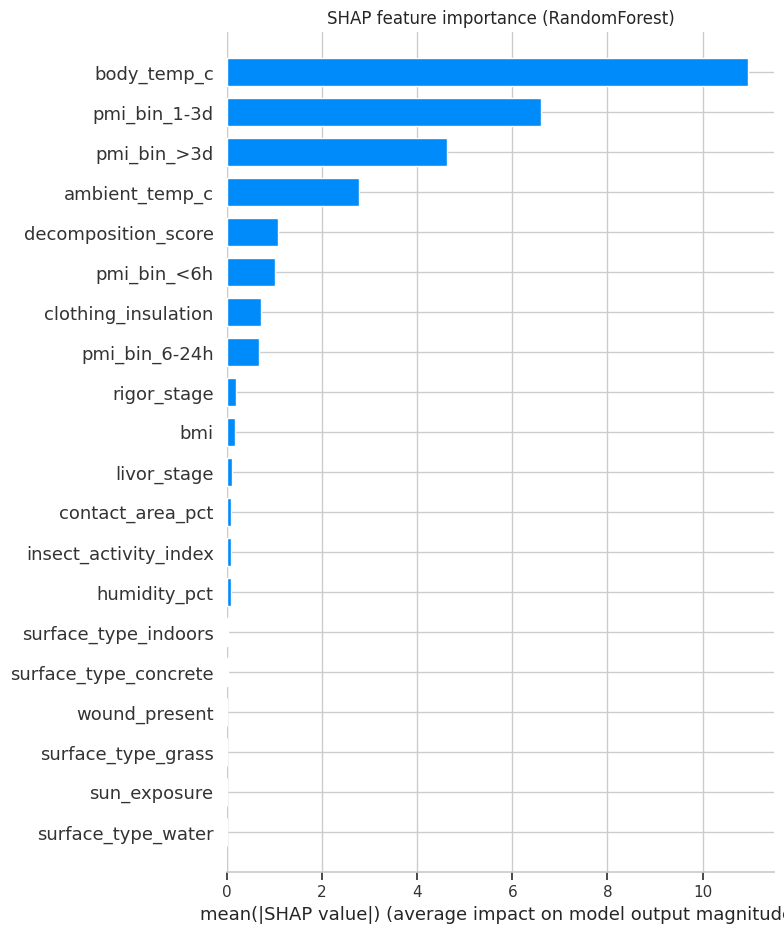

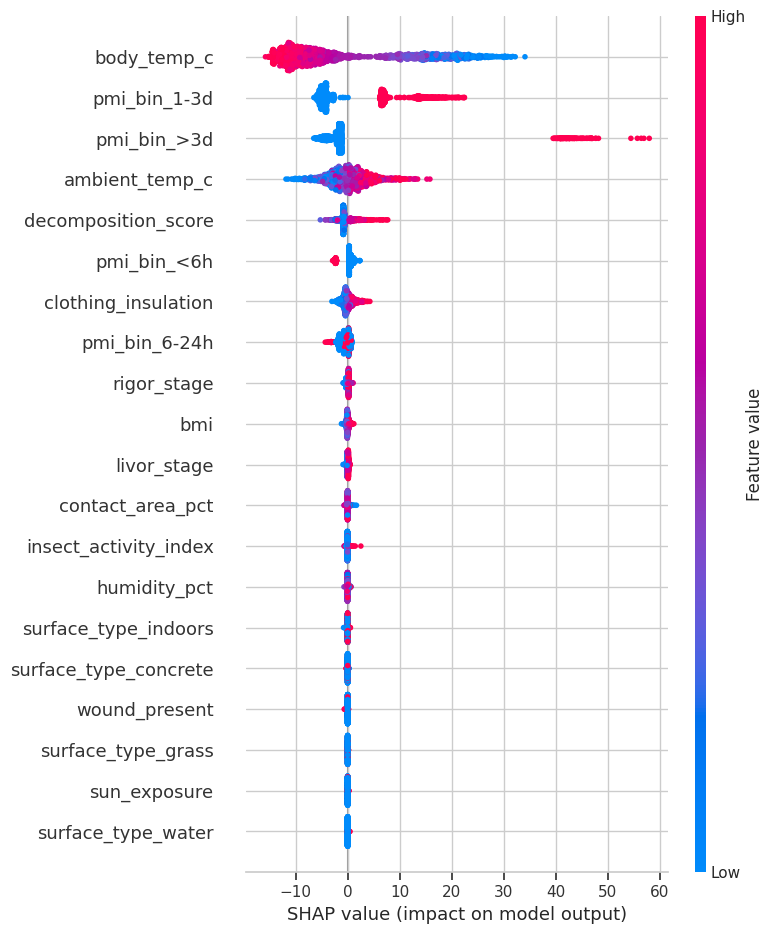

In [23]:
# Extract trained tree model and transformed data for SHAP
rf_model = rf_pipeline.named_steps['model']
X_test_trans = preprocessor.transform(X_test)

# Create TreeExplainer
explainer = shap.TreeExplainer(rf_model)
# shap_values shape: (n_samples, n_transformed_features)
shap_values = explainer.shap_values(X_test_trans)

# Global summary plot (bar)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP feature importance (RandomForest)")
plt.tight_layout()
plt.show()

# Detailed summary (beeswarm)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()


Local explanation (SHAP force plot) for a single example

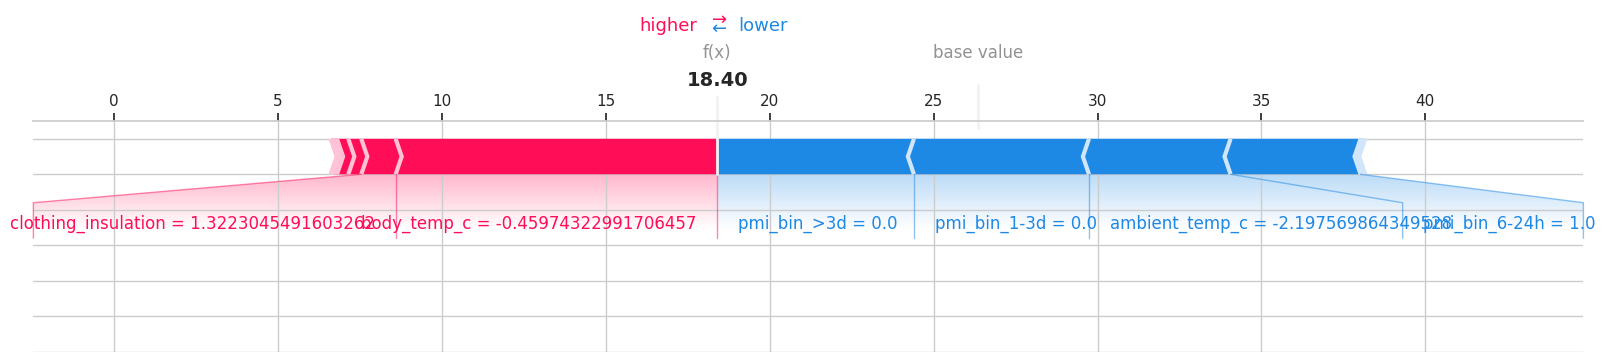

None

In [24]:
# Show a local explanation for a single test sample index
sample_idx = 7  # change as needed (index within X_test)
x_sample = X_test.iloc[sample_idx:sample_idx+1]
x_trans_sample = preprocessor.transform(x_sample)

# Use shap to show local contributions
shap.initjs()
shap_value_sample = explainer.shap_values(x_trans_sample)
# Force plot (works well in notebook output)
display(shap.force_plot(explainer.expected_value, shap_value_sample, x_trans_sample, feature_names=feature_names, matplotlib=True))


Coefficients for Lasso

In [26]:
# For Lasso: inspect coefficients mapping back to feature names
lasso_model = lasso_pipeline.named_steps['model']
X_train_trans = preprocessor.transform(X_train)
coef = lasso_model.coef_

# ensure same length
feat_names = get_feature_names(preprocessor)
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coef})

# sort by absolute coefficient magnitude (largest effects first)
coef_df = coef_df.sort_values(by='coef', key=lambda x: np.abs(x), ascending=False)

coef_df.head(20)


,feature,coef
20,pmi_bin_>3d,32.299068
0,body_temp_c,-12.272394
19,pmi_bin_<6h,-6.138760
17,pmi_bin_1-3d,5.721397
1,ambient_temp_c,5.100571
18,pmi_bin_6-24h,-3.863707
8,decomposition_score,2.911075
3,clothing_insulation,0.903605
9,insect_activity_index,0.823121
15,surface_type_indoors,0.792280


Save best model and metrics

In [27]:
os.makedirs("models", exist_ok=True)
best_model = None
best_name = None
# pick best by MAE
models_metrics = {
    'Lasso': metrics_lasso,
    'RandomForest': metrics_rf,
    'XGBoost': metrics_xgb
}
best_name = min(models_metrics, key=lambda m: models_metrics[m]['MAE'])
print("Best model by MAE:", best_name)
if best_name == 'Lasso':
    best_model = lasso_pipeline
elif best_name == 'RandomForest':
    best_model = rf_pipeline
else:
    best_model = xgb_pipeline

# Save pipeline
model_path = f"models/best_model_{best_name}_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.joblib"
joblib.dump(best_model, model_path)
print("Saved best model to:", model_path)

# Save metrics
metrics_df.to_csv("models/model_metrics_summary.csv")
print("Saved metrics to models/model_metrics_summary.csv")


Best model by MAE: RandomForest


/tmp/ipython-input-1386556667.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  model_path = f"models/best_model_{best_name}_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.joblib"


Saved best model to: models/best_model_RandomForest_20251108T143105Z.joblib
Saved metrics to models/model_metrics_summary.csv


Diagnostics: residuals distribution

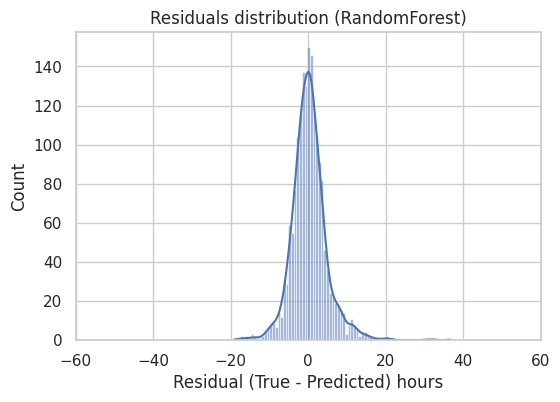

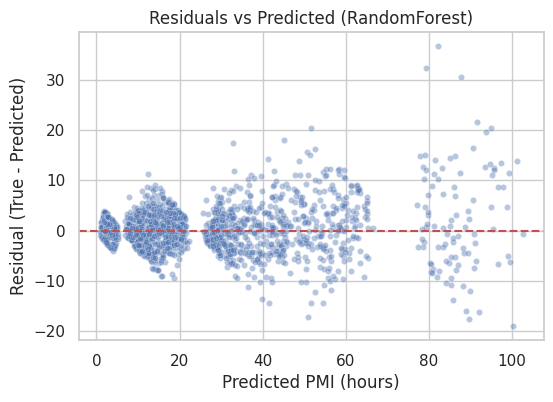

In [28]:
resids = y_test - (y_pred_rf)
plt.figure(figsize=(6,4))
sns.histplot(resids, bins=80, kde=True)
plt.title("Residuals distribution (RandomForest)")
plt.xlabel("Residual (True - Predicted) hours")
plt.xlim(-60,60)
plt.show()

# residuals vs predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_rf, y=resids, alpha=0.4, s=20)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted PMI (hours)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs Predicted (RandomForest)")
plt.show()


Save SHAP values for later analysis

In [29]:
os.makedirs("explanations", exist_ok=True)
# Save shap values and test data (numpy arrays and CSV for feature names)
np.save("explanations/shap_values_rf.npy", shap_values)
np.save("explanations/X_test_trans.npy", X_test_trans)
pd.Series(feature_names).to_csv("explanations/feature_names_transformed.csv", index=False)
print("Saved SHAP arrays and feature names to explanations/")


Saved SHAP arrays and feature names to explanations/
